In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import font_manager, rc
import plotly.express as px
import datetime as dt

In [ ]:
df = pd.read_excel('미니프로젝트-쇼핑몰 실습데이터.xlsx')
df2 = df.copy()
purchase = df2[df2['처리상태'] == '구매확정']     # 구매확정인 값만 출력
purchase = purchase.loc[:, (purchase.columns != '초도상품') & (purchase.columns != '제작문구 내역')]     # 필요없는 변수 제거
purchase = purchase.replace('지니 태블릿(후불집행)','지니 태블릿')
purchase = purchase.reset_index(drop = True)     # 인덱스 초기화

## 2. 월별, 연도별 시각화


### 연도별, 월별 나누기

In [24]:
purchase['연도'] = purchase['주문일자'].dt.year
purchase['월'] = purchase['주문일자'].dt.month 

### 할부기간 적용 항목 추출을 위한 데이터 세팅
   - 할부기간 1개월 항목은 결측치로 마스킹 후 제거
   - '업체명', '연도', '월', '할부기간' 컬럼들만 따로 추출
   - '할부기간'에 '개월' 문자열을 슬라이싱 하기위한 convert() 함수 정의 및 사용

In [25]:

df2 = purchase
m = df2['할부기간'] == '1개월' 
df2 = df2.loc[df2['할부기간'] != '1개월']
df2 = df2.dropna(axis=0)
df2_sell = df2[['업체명', '연도', '월', '할부기간']]
df2_sell['판매금액'] = df2['판매금액']

def convert(x):
    return int(x[:-2])


index = df2_sell['할부기간'].index
df2_sell['할부기간'] = df2_sell['할부기간'].apply(lambda x: convert(x))
df2_sell

C:\Users\user\AppData\Local\Temp\ipykernel_18792\2857142513.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_18792\2857142513.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,업체명,연도,월,할부기간,판매금액
16676,지니 태블릿,2020,10,12,768000
16680,지니 태블릿,2020,10,12,1920000
16681,지니 태블릿,2020,10,12,768000
16703,지니 태블릿,2020,10,24,1920000
16704,지니 태블릿,2020,10,24,1920000
...,...,...,...,...,...
156132,천재태블릿,2022,10,18,1980000
156804,천재태블릿,2022,10,18,3168000
156918,천재태블릿,2022,10,12,396000
157563,천재태블릿,2022,10,12,396000


### 할부기간 적용 항목들 월별로 할부금액 합산

   - 할부기간 1개월 항목은 결측치로 마스킹 후 제거
   - '업체명', '연도', '월', '할부기간' 컬럼들만 따로 추출
   - '할부기간'에 '개월' 문자열을 슬라이싱 하기위한 convert() 함수 정의 및 사용

In [26]:


monthly_price = df2_sell['판매금액']/df2_sell['할부기간']

year = list(df2_sell['연도'].unique())
month = list(df2_sell['월'].unique())
last_date = df2_sell['연도'].values.max(), df2_sell['월'].values.max(), df2_sell['할부기간'].values.max()

plus = (last_date[1] + last_date[2])//12

for i in range(plus):
    year.append(last_date[0]+i+1)

delay_payment = {year[i]: {month[j]: 0 for j in range(len(month))} for i in range(len(year))}
## 연도별과 월별 총매출금액 정보의 빈 딕션너리 생성

   
month_count = 0
for i in monthly_price.index:             ## 각 해당 값 채워넣는 작업
    price = monthly_price[i]
    starting_month = df2_sell['월'][i]
    starting_year = df2_sell['연도'][i]
    for j in range(df2_sell['할부기간'][i]):
        if starting_year not in year:
            break
        delay_payment[starting_year][starting_month] += price
        starting_month += 1
        if starting_month > 12:
            starting_year += 1
            starting_month = 1

print(delay_payment)

{2020: {10: 15408000.0, 12: 27552000.0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 11: 15408000.0}, 2021: {10: 51691000.0, 12: 50794500.0, 1: 31809000.0, 2: 35571000.0, 3: 42259000.0, 4: 46450000.0, 5: 50047000.0, 6: 49398000.0, 7: 54045500.0, 8: 56383000.0, 9: 55899000.0, 11: 53583000.0}, 2022: {10: 36481500.0, 12: 27197500.0, 1: 49128000.0, 2: 49463500.0, 3: 50321500.0, 4: 48407500.0, 5: 51790000.0, 6: 49546000.0, 7: 47021500.0, 8: 46658500.0, 9: 45498000.0, 11: 32488500.0}, 2023: {10: 4790500.0, 12: 3025000.0, 1: 24711500.0, 2: 20641500.0, 3: 16769500.0, 4: 14327500.0, 5: 10983500.0, 6: 10224500.0, 7: 8591000.0, 8: 6968500.0, 9: 5945500.0, 11: 3437500.0}, 2024: {10: 0, 12: 0, 1: 2678500.0, 2: 2497000.0, 3: 1903000.0, 4: 1122000.0, 5: 940500.0, 6: 940500.0, 7: 693000.0, 8: 495000.0, 9: 82500.0, 11: 0}, 2025: {10: 0, 12: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 11: 0}}


#### 할부기간중 총금액을 딕셔너리 내 합산값과 비교 (같아야함)

In [27]:
print(df2_sell['판매금액'].sum()) ## 할부기간 계산전 총액

cal = 0
for i in delay_payment.values():
    for j in i:
        cal += i[j]
print(cal)   ## 할부기간 계산 후 총액 

1312068000
1312068000.0


### 연도별, 월별 매출 시각화 진행

In [28]:
df3 = purchase[['연도', '월', '할부기간']]
df3['판매금액'] = purchase['판매금액']
df3

C:\Users\user\AppData\Local\Temp\ipykernel_18792\1520013784.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,연도,월,할부기간,판매금액
0,2019,12,NaN,5000
1,2019,12,NaN,5000
2,2019,12,NaN,67500
3,2019,12,NaN,30000
4,2019,12,NaN,750
...,...,...,...,...
159286,2022,11,NaN,19200
159287,2022,11,NaN,2550
159288,2022,11,NaN,1800
159289,2022,11,NaN,3400


### 연도에 따른 입점 업체 수

In [29]:
unique_counts = purchase.groupby('연도')['업체명'].nunique()
purchase['업체수'] = purchase['연도'].map(unique_counts)

In [30]:
ddf1 = purchase.groupby(['연도', '업체수','업체명']).agg({'판매금액':'sum'}).sort_values(by=['연도', '판매금액'], ascending=False)

In [31]:
ddf1 = ddf1.reset_index(level = 0)

In [32]:
ddf1

연도        판매금액
업체수 업체명                     
64  다우기술    2022  1703529790
    지니 태블릿  2022  1002276000
    천재태블릿   2022   967032000
    지니      2022   335132215
    에이스디포   2022    74152300
...          ...         ...
57  셀러테스트   2020       10000
4   지니      2019     4100600
    라온웍스    2019      446100
    쥬크박스    2019      278980
    조이스     2019      181900

[178 rows x 2 columns]

In [33]:
ddf2= ddf1.reset_index()
ddf2

,업체수,업체명,연도,판매금액
0,64,다우기술,2022,1703529790
1,64,지니 태블릿,2022,1002276000
2,64,천재태블릿,2022,967032000
3,64,지니,2022,335132215
4,64,에이스디포,2022,74152300
...,...,...,...,...
173,57,셀러테스트,2020,10000
174,4,지니,2019,4100600
175,4,라온웍스,2019,446100
176,4,쥬크박스,2019,278980


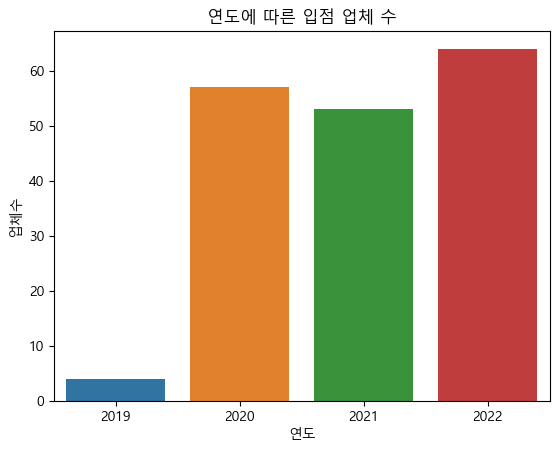

In [34]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
sns.barplot(x='연도', y='업체수', data=ddf2)
plt.title('연도에 따른 입점 업체 수')
plt.show()

### 연도별 매출 시각화

C:\Users\user\AppData\Local\Temp\ipykernel_18792\3726025313.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator



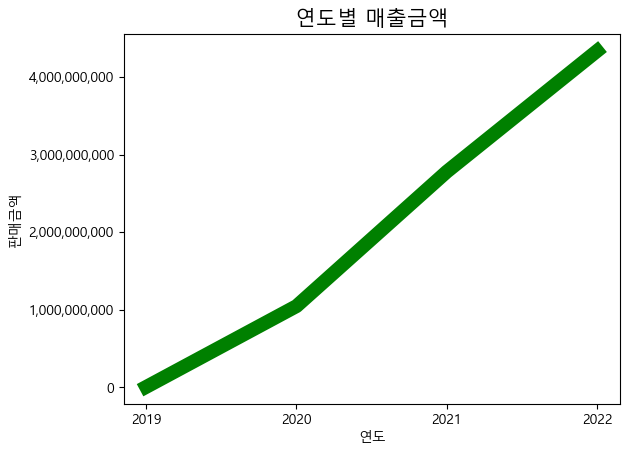

In [35]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

plt.plot(df3.groupby('연도')['판매금액'].sum(),color = 'green',linewidth = '10')
plt.xticks(range(2019,2023))
plt.xlabel('연도')
plt.ylabel('판매금액')
plt.title('연도별 매출금액', fontsize=15)

# 지수표현 변경하고 천단위 컴마
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


plt.savefig('시각.png')

### 월별 매출 시각화


C:\Users\user\AppData\Local\Temp\ipykernel_18792\1110514272.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 0, '월')

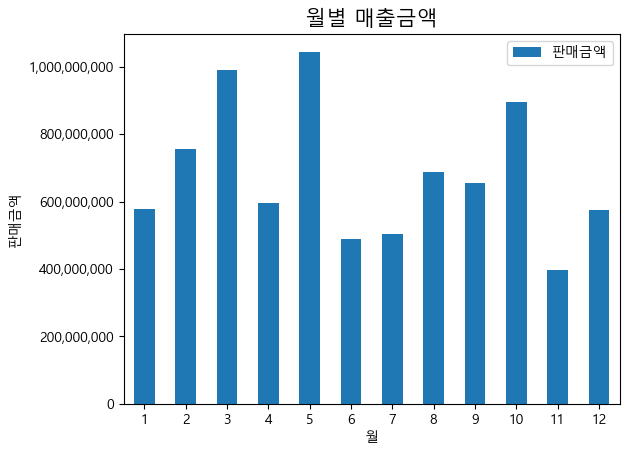

In [36]:
ddf3 = df3.groupby(['월']).agg({'판매금액':'sum'})

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


ddf3 = ddf3.reset_index()
ddf3.plot.bar(x='월', y='판매금액',rot=0)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.title('월별 매출금액', fontsize=15)
plt.ylabel('판매금액')
plt.xlabel('월')

### 할부기간 적용, 미적용 항목 분류작업
    - 할부기간이 없는 항목들로 마스킹
    - 할부청산 제외 월별 총 매출

In [37]:
df3_sell = df3.query('할부기간.isna()')  
df3_sell = df3_sell.groupby(['월']).agg({'판매금액':'sum'}) 
df3_sell

,판매금액
월,
1,495271300
2,650711825
3,840892885
4,499413808
5,929989970
6,428194235
7,387190990
8,599827760
9,583829140


#### 환불처리 월별 총 매출 계산값 데이터셋

In [38]:
df4 = pd.DataFrame.from_dict(data=delay_payment, orient='columns').sort_index() 
df4

,2020,2021,2022,2023,2024,2025
1,0.0,31809000.0,49128000.0,24711500.0,2678500.0,0
2,0.0,35571000.0,49463500.0,20641500.0,2497000.0,0
3,0.0,42259000.0,50321500.0,16769500.0,1903000.0,0
4,0.0,46450000.0,48407500.0,14327500.0,1122000.0,0
5,0.0,50047000.0,51790000.0,10983500.0,940500.0,0
6,0.0,49398000.0,49546000.0,10224500.0,940500.0,0
7,0.0,54045500.0,47021500.0,8591000.0,693000.0,0
8,0.0,56383000.0,46658500.0,6968500.0,495000.0,0
9,0.0,55899000.0,45498000.0,5945500.0,82500.0,0
10,15408000.0,51691000.0,36481500.0,4790500.0,0.0,0


#### 할부기간 적용 항목과 미적용 항목들 월별 매출 합산

In [39]:
for i in df4:
    df3_sell['판매금액'] += df4[i]
    
df3_sell

,판매금액
월,
1,6.035983e+08
2,7.588848e+08
3,9.521459e+08
4,6.097208e+08
5,1.043751e+09
6,5.383032e+08
7,4.975420e+08
8,7.103328e+08
9,6.912541e+08


### 쇼핑몰 월별 순이익 매출 시각화

C:\Users\user\AppData\Local\Temp\ipykernel_18792\136344649.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 1.0, '월별 순이익')

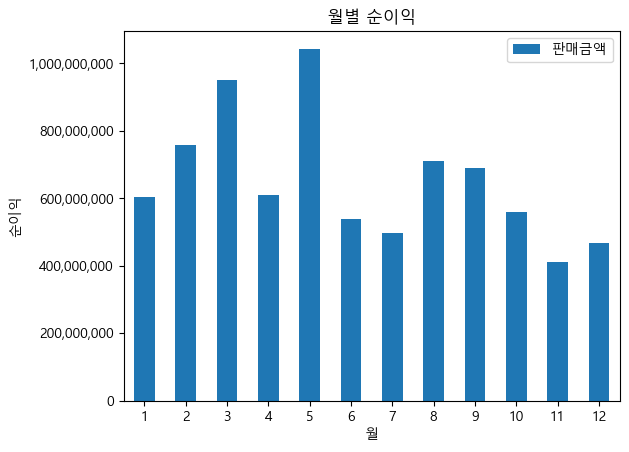

In [40]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)



df3_sell2 = df3_sell.reset_index()
df3_sell2.plot.bar(x='월', y='판매금액',rot=0)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('순이익')
plt.xlabel('월')
plt.title('월별 순이익')


### 업체별 월별 매출 현황 분석

In [41]:
df1_sell = purchase[['업체명', '연도', '월', '할부기간']]
df1_sell['판매금액'] = purchase['판매금액']
df1_sell  ## 할부기간 미적용 항목들

C:\Users\user\AppData\Local\Temp\ipykernel_18792\72139898.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,업체명,연도,월,할부기간,판매금액
0,지니,2019,12,NaN,5000
1,지니,2019,12,NaN,5000
2,지니,2019,12,NaN,67500
3,지니,2019,12,NaN,30000
4,지니,2019,12,NaN,750
...,...,...,...,...,...
159286,다우기술,2022,11,NaN,19200
159287,다우기술,2022,11,NaN,2550
159288,다우기술,2022,11,NaN,1800
159289,다우기술,2022,11,NaN,3400


In [42]:
df2_sell ## 할부기간 적용 항목들

,업체명,연도,월,할부기간,판매금액
16676,지니 태블릿,2020,10,12,768000
16680,지니 태블릿,2020,10,12,1920000
16681,지니 태블릿,2020,10,12,768000
16703,지니 태블릿,2020,10,24,1920000
16704,지니 태블릿,2020,10,24,1920000
...,...,...,...,...,...
156132,천재태블릿,2022,10,18,1980000
156804,천재태블릿,2022,10,18,3168000
156918,천재태블릿,2022,10,12,396000
157563,천재태블릿,2022,10,12,396000


In [43]:
## 할부기간 미적용 항목들 기업별 매출 확인

df1_sell = df1_sell.groupby([ '업체명', '월']).agg({'판매금액':'sum'})
df1_sell


판매금액
업체명    월         
가베     1   522900
       2   491800
       3   566700
       4   564300
       5    41700
...           ...
행복한바오밥 9   259000
       10  126600
       11  115850
       12  171500
헬스하우스  5   193500

[608 rows x 1 columns]

### 할부기간 적용 항목들 기업별 매출 확인
  

In [44]:


monthly_price = df2_sell['판매금액']/df2_sell['할부기간']
company = df2_sell['업체명'].unique()
month = list(df2_sell['월'].unique())
last_date = df2_sell['연도'].values.max(), df2_sell['월'].values.max(), df2_sell['할부기간'].values.max()

delay_payment2 = {i: {month[j]: 0 for j in range(len(month))} for i in company}
## 업체명과 월별 매출금액 정보의 빈 딕션너리 생성
   
month_count = 0
for i in monthly_price.index:      ## 각 해당 값 채워넣는 작업
    price = monthly_price[i]
    starting_month = df2_sell['월'][i]
    ini_company = df2_sell['업체명'][i]
    for j in range(df2_sell['할부기간'][i]):
        if starting_year not in year:
            break
        delay_payment2[ini_company][starting_month] += price
        starting_month += 1
        if starting_month > 12:
            starting_month = 1
print(delay_payment2)

{'지니 태블릿': {10: 63304000.0, 12: 64910000.0, 1: 65394000.0, 2: 66516000.0, 3: 69904000.0, 4: 71158000.0, 5: 72544000.0, 6: 69552000.0, 7: 69068000.0, 8: 67946000.0, 9: 64558000.0, 11: 61918000.0}, '천재태블릿': {10: 45067000.0, 12: 43659000.0, 1: 42933000.0, 2: 41657000.0, 3: 41349000.0, 4: 39149000.0, 5: 41217000.0, 6: 40557000.0, 7: 41283000.0, 8: 42559000.0, 9: 42867000.0, 11: 42999000.0}}


### 할부 적용 항목들과 미적용 항목들 합산

In [45]:
for key, value in delay_payment2.items():
    for i,j in value.items():
        df1_sell.loc[key, i] = j


### 기업별 월별 순수익

In [46]:
df1_sell

판매금액
업체명    월         
가베     1   522900
       2   491800
       3   566700
       4   564300
       5    41700
...           ...
행복한바오밥 9   259000
       10  126600
       11  115850
       12  171500
헬스하우스  5   193500

[608 rows x 1 columns]

#### 인덱싱 리셋 작업

In [47]:
df1_sell2 = df1_sell.reset_index()
df1_sell2

,업체명,월,판매금액
0,가베,1,522900
1,가베,2,491800
2,가베,3,566700
3,가베,4,564300
4,가베,5,41700
...,...,...,...
603,행복한바오밥,9,259000
604,행복한바오밥,10,126600
605,행복한바오밥,11,115850
606,행복한바오밥,12,171500


### 월별 순이익 최고매출 업체 


In [48]:
## 월별 순이익 매출

ddf = pd.DataFrame()
for i in range(1,13):
    data = df1_sell2.query(f'월 == {i}')
    m =  data['판매금액'] == data['판매금액'].max()
    max_data = data[m]
    ddf[f'{i}월'] = max_data['업체명'].values[0], max_data['판매금액'].values[0], 

ddf = ddf.transpose()
ddf

,0,1
1월,다우기술,303962860
2월,다우기술,338185830
3월,다우기술,170189440
4월,다우기술,96960668
5월,다우기술,275833955
6월,다우기술,189960475
7월,다우기술,161371695
8월,다우기술,365651615
9월,다우기술,373163220
10월,다우기술,219890278
